### Richard Castaneda LSTM Midterm ###

In [7]:
# IMPORT BASIC lIBRARIES

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# For timeseries RNN LSTM neural network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [9]:
# IMPORT KERAS: TimeseriesGenerator
#This class produce time series batches use on training/testing the model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# IMPORT KERAS: MinMaxScaler
# This class is used to pre process (scale) the data
from sklearn.preprocessing import MinMaxScaler

In [10]:
dfTSLA = 'Downloads/TSLA.csv'

In [11]:
df_ALL = pd.read_csv(dfTSLA)

In [12]:
df_ALL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/5/2018,22.159332,22.516666,21.952667,22.223333,22.223333,57357000
1,3/6/2018,22.250000,22.424667,21.802000,21.879999,21.879999,64285500
2,3/7/2018,21.695999,22.166668,21.449333,22.153334,22.153334,75109500
3,3/8/2018,22.190666,22.219999,21.751333,21.940001,21.940001,53493000
4,3/9/2018,21.606667,21.899332,21.491333,21.811333,21.811333,82602000


In [13]:
df_ALL.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1136,9/7/2022,273.100006,283.839996,272.269989,283.700012,283.700012,50028900
1137,9/8/2022,281.299988,289.500000,279.760010,289.260010,289.260010,53713100
1138,9/9/2022,291.670013,299.850006,291.250000,299.679993,299.679993,54338100
1139,9/12/2022,300.720001,305.489990,300.399994,304.420013,304.420013,48674600
1140,9/13/2022,292.899994,297.399994,290.399994,292.130005,292.130005,68229600


### Brief Exploratory Data Analyis EDA ###

In [14]:
df_ALL.shape

(1141, 7)

In [15]:
df_ALL.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [16]:
# Statistics Summary
df_ALL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1.141000e+03
mean,130.863064,133.897266,127.567752,130.826040,130.826040,1.363922e+08
std,119.920816,122.640329,116.838017,119.767818,119.767818,9.309932e+07
min,12.073333,12.445333,11.799333,11.931333,11.931333,2.940180e+07
25%,20.489332,20.966667,20.070000,20.582666,20.582666,7.689750e+07
50%,61.566666,64.599335,60.610668,62.711334,62.711334,1.044990e+08
75%,237.570007,243.576660,233.626663,237.919998,237.919998,1.627245e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [17]:
df = df_ALL.iloc[:,4:5]

In [18]:
df.head()

,Close
0,22.223333
1,21.879999
2,22.153334
3,21.940001
4,21.811333


<AxesSubplot: >

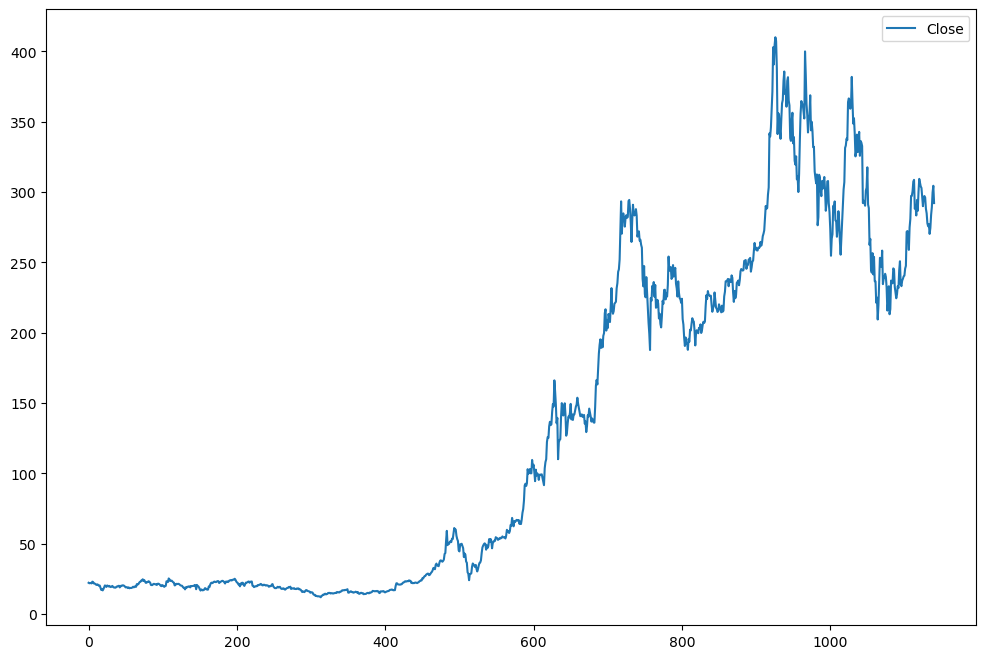

In [19]:
df.plot(figsize=(12,8))

### Set length of the input sequence  ###

In [20]:
# Set length of the input sequence 
#i.e time series steps that are used for future predictions
#Currently us 100 historical data points
length100 = 100

In [22]:
length100

100

In [24]:
len(df)

1141

In [36]:
# Set percentage 
test_percent = 0.3

In [37]:
#Number of data points reserved for testing 
# 100 percent
len(df)*test_percent

342.3

In [38]:
# Need to find the length of testing datasets
test_length = np.round(len(df)*test_percent)

test_length

342.0

In [39]:
# Testing data set starts at this index
split_index = int(len(df) - test_length)

split_index

799

In [40]:
# The testing data set starts at this index
data_train = df.iloc[: split_index]

# Testing dataset
data_test = df.iloc[split_index - length100 :]

In [41]:
data_train.head(5)

,Close
0,22.223333
1,21.879999
2,22.153334
3,21.940001
4,21.811333


In [42]:
data_train.tail()

,Close
794,225.666672
795,236.479996
796,228.300003
797,224.533340
798,223.646667


In [43]:
data_test.head(5)

,Close
699,209.023331
700,203.330002
701,213.276672
702,211.083328
703,207.589996


In [44]:
data_test.tail()

,Close
1136,283.700012
1137,289.260010
1138,299.679993
1139,304.420013
1140,292.130005


### Normalize Data (Scale it into the range [0,1]) ###

In [45]:
# Create a MinMaxScaler to normalize the data
scaler = MinMaxScaler()

In [46]:
# ONLY scale the traing data - Not scale the testing data

scaler.fit(data_train)

MinMaxScaler()

In [47]:
normalized_train = scaler.transform(data_train)

normalized_test = scaler.transform(data_test)

### Create TimeseriesGenerator for Training ###

In [48]:
# TimeseriesGenerator : Generate time series batches for traing/testing
#Set the length of the input sequence as above
#length60
batch_size64 = 64

#Create a TimeSeriesGenerator for training: train_tsGenerator
# TS (inputs, outpus, length, batch_size)
train_tsGenerator100 = TimeseriesGenerator(normalized_train, normalized_train, length=length100, batch_size=batch_size64)

In [49]:
len(normalized_train)

799

In [51]:
len(train_tsGenerator100)

11

In [52]:
#What does the first batch look like?
X,y = train_tsGenerator100[0]

In [53]:
# print(X)

In [54]:
# print(y)

# Build, Train, and Test Model #

### Build LTSM Model ###

In [55]:
# Set number of features

# Only using one feature: Close price
n_features = 1

In [57]:
# define model
model = Sequential()

# Add on LSTM layer
# This layer has 100 LSTM cells
# Activation fuctions: relu
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(length100, n_features)))

# Dropout layer
model.add(Dropout(0.25))

model.add(LSTM(units=100, activation='relu', return_sequences=True))

model.add(Dropout(0.25))

model.add(LSTM(units=100, activation='relu'))

model.add(Dense(1))

### Compile Model ###

In [58]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-tr

In [60]:
model.fit(train_tsGenerator100, epochs=50)

Epoch 1/50
11/11 [==============================] - 6s 328ms/step - loss: 0.0818
Epoch 2/50
11/11 [==============================] - 2s 202ms/step - loss: 0.0326
Epoch 3/50
11/11 [==============================] - 11s 945ms/step - loss: 0.0304
Epoch 4/50
11/11 [==============================] - 5s 462ms/step - loss: 0.0365
Epoch 5/50
11/11 [==============================] - 7s 524ms/step - loss: 0.0647
Epoch 6/50
11/11 [==============================] - 5s 517ms/step - loss: 0.0620
Epoch 7/50
11/11 [==============================] - 7s 699ms/step - loss: 0.0321
Epoch 8/50
11/11 [==============================] - 5s 447ms/step - loss: 0.0367
Epoch 9/50
11/11 [==============================] - 4s 397ms/step - loss: 0.0173
Epoch 10/50
11/11 [==============================] - 6s 555ms/step - loss: 0.0394
Epoch 11/50
11/11 [==============================] - 5s 417ms/step - loss: 0.0212
Epoch 12/50
11/11 [==============================] - 4s 346ms/step - loss: 0.0032
Epoch 13/50
11/11 [=====

## Visualize Models Performance after Training ##

In [61]:
loss_history_keys = model.history.history.keys()
loss_history_keys

dict_keys(['loss'])

<AxesSubplot: >

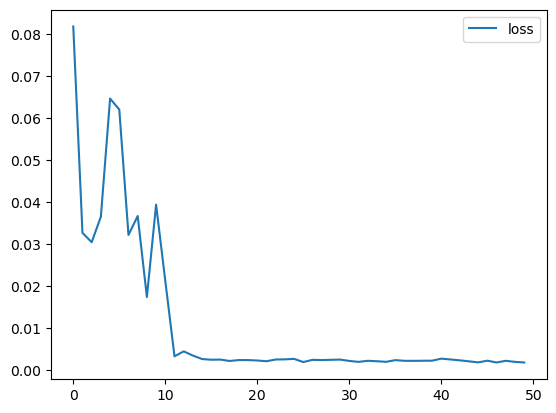

In [62]:
df_model_loss = pd.DataFrame(model.history.history)
df_model_loss.plot()

### Prediction for Testing: Using TimeseriesGenerator ###

In [64]:
batch_size1 = 1
test_tsGenerator100 = TimeseriesGenerator(normalized_test, normalized_test, length=length100, batch_size=batch_size1)

In [66]:
normalized_prediction = model.predict(test_tsGenerator100) 

342/342 [==============================] - 5s 14ms/step


In [67]:
normalized_prediction

array([[0.7495284 ],
       [0.74433464],
       [0.73880744],
       [0.73251206],
       [0.7252723 ],
       [0.71676874],
       [0.70683867],
       [0.69606495],
       [0.6847803 ],
       [0.67343765],
       [0.6622119 ],
       [0.65178406],
       [0.6424474 ],
       [0.63482493],
       [0.6290955 ],
       [0.62547237],
       [0.6240601 ],
       [0.62455213],
       [0.626541  ],
       [0.62928647],
       [0.63174254],
       [0.63384575],
       [0.63565385],
       [0.63717824],
       [0.63835883],
       [0.6393965 ],
       [0.64038193],
       [0.64148897],
       [0.6424547 ],
       [0.6432605 ],
       [0.6440986 ],
       [0.6451546 ],
       [0.6464327 ],
       [0.6479408 ],
       [0.65018845],
       [0.6536596 ],
       [0.658246  ],
       [0.663973  ],
       [0.670472  ],
       [0.6773481 ],
       [0.68421483],
       [0.69078106],
       [0.69648623],
       [0.70081323],
       [0.7037532 ],
       [0.7054851 ],
       [0.70671827],
       [0.707

In [68]:
len(normalized_prediction)

342

In [69]:
# convert normalized predictions back to the true values
prediction = scaler.inverse_transform(normalized_prediction)

In [72]:
prediction_index = np.arange(799, 1141, step=1)

df_prediction = pd.DataFrame(data=prediction, index=prediction_index, columns=['Prediction'])

In [73]:
df_prediction

,Prediction
799,223.622147
800,222.155258
801,220.594208
802,218.816177
803,216.771439
...,...
1136,262.991577
1137,261.064240
1138,259.477966
1139,258.468872


<AxesSubplot: >

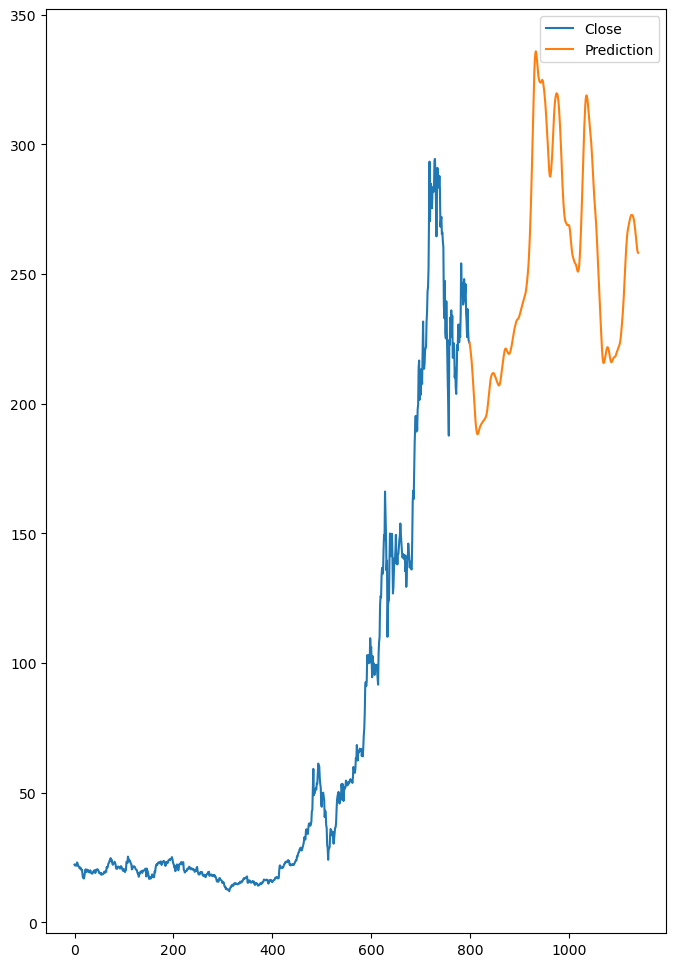

In [74]:
ax = data_train.plot()
df_prediction.plot(ax=ax, figsize=(8, 12))

<AxesSubplot: >

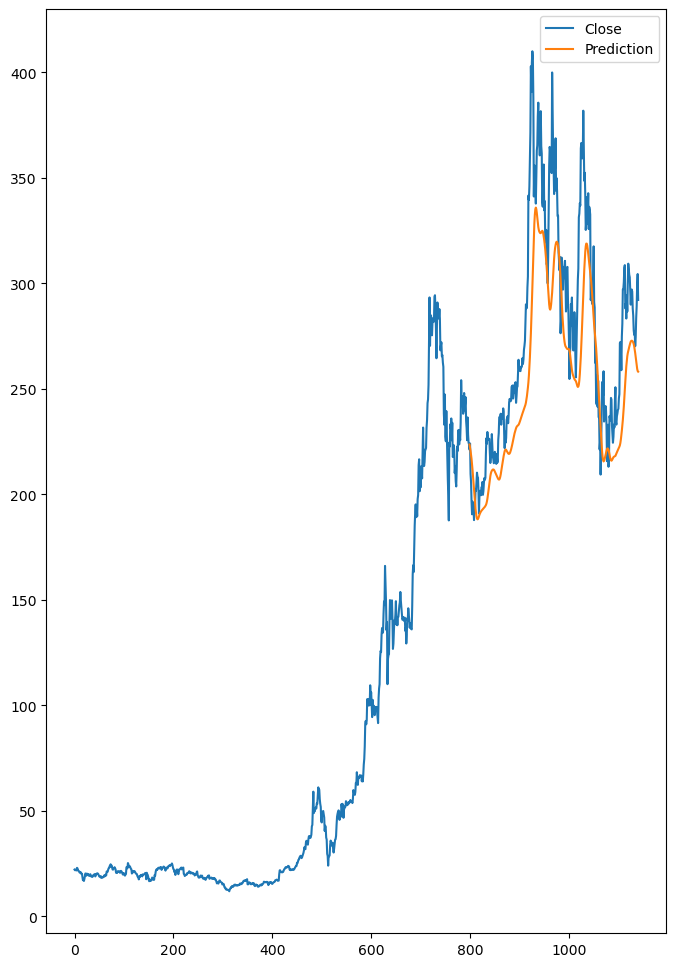

In [75]:
ax = df.plot()
df_prediction.plot(ax=ax, figsize=(8, 12))

# Time Series Forecasting with LSTM

# Overview


### Time Series forecasting:


### --) Forecast into the "Future" or unknown range


### --)Should employ all the available data


### --)i.e., NOt spilt the data into training/testing

In [76]:
#Still use Minmax Scaler to normalize the full input dataset

full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

In [78]:
# create timeseries Generator for forecasting
forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length=length100, batch_size=batch_size64)

In [82]:
forecast = []
# Set periods with the time span of forecasting
# Let's forecast for the next 117 business days (03/05/2022 - 12/15/2022)
periods = 117

first_eval_batch = normalized_full_data[-length100:]
current_batch = first_eval_batch.reshape((1, length100, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


# Inverse to Transform Normalized Data Back into True Values

In [83]:
forecast = full_scaler.inverse_transform(forecast)

forecast

array([[271.53112557],
       [271.74090161],
       [271.79022578],
       [271.57980917],
       [271.08825186],
       [270.34143778],
       [269.38691173],
       [268.27781761],
       [267.06378801],
       [265.78657887],
       [264.47871709],
       [263.1640937 ],
       [261.85891284],
       [260.57368466],
       [259.31441158],
       [258.0843202 ],
       [256.8843595 ],
       [255.7145295 ],
       [254.57423706],
       [253.46239085],
       [252.37820793],
       [251.32059695],
       [250.28875128],
       [249.28205406],
       [248.29972236],
       [247.34132914],
       [246.40632873],
       [245.49419917],
       [244.60458459],
       [243.73710539],
       [242.89119218],
       [242.06644163],
       [241.26237923],
       [240.47864912],
       [239.71472934],
       [238.97014541],
       [238.24454143],
       [237.53727684],
       [236.84813812],
       [236.17646097],
       [235.52203185],
       [234.88416275],
       [234.2626876 ],
       [233

In [84]:
df

,Close
0,22.223333
1,21.879999
2,22.153334
3,21.940001
4,21.811333
...,...
1136,283.700012
1137,289.260010
1138,299.679993
1139,304.420013


In [85]:
# calculate forecast index

forecast_index = np.arange(1141, 1258, step=1)

In [86]:
forecast_df=pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [87]:
forecast_df

,Forecast
1141,271.531126
1142,271.740902
1143,271.790226
1144,271.579809
1145,271.088252
...,...
1253,213.913344
1254,213.794292
1255,213.677661
1256,213.563425


<AxesSubplot: >

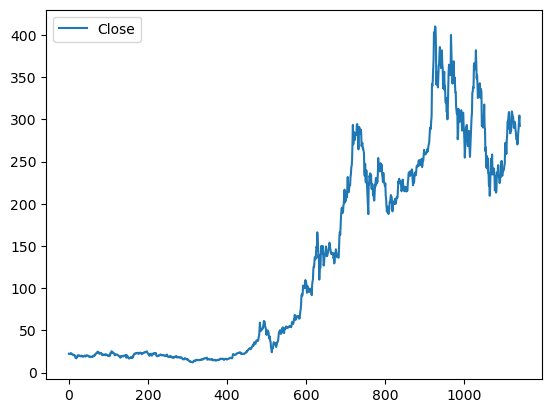

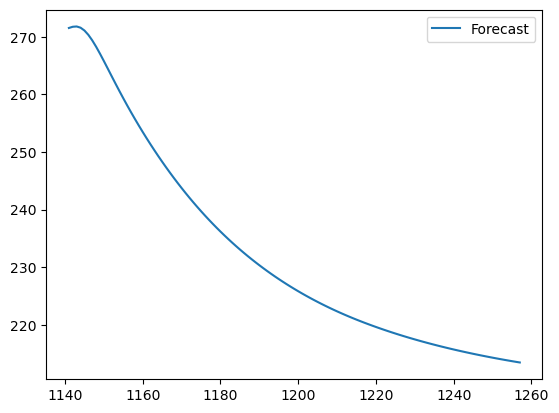

In [88]:
df.plot()
forecast_df.plot()

<AxesSubplot: >

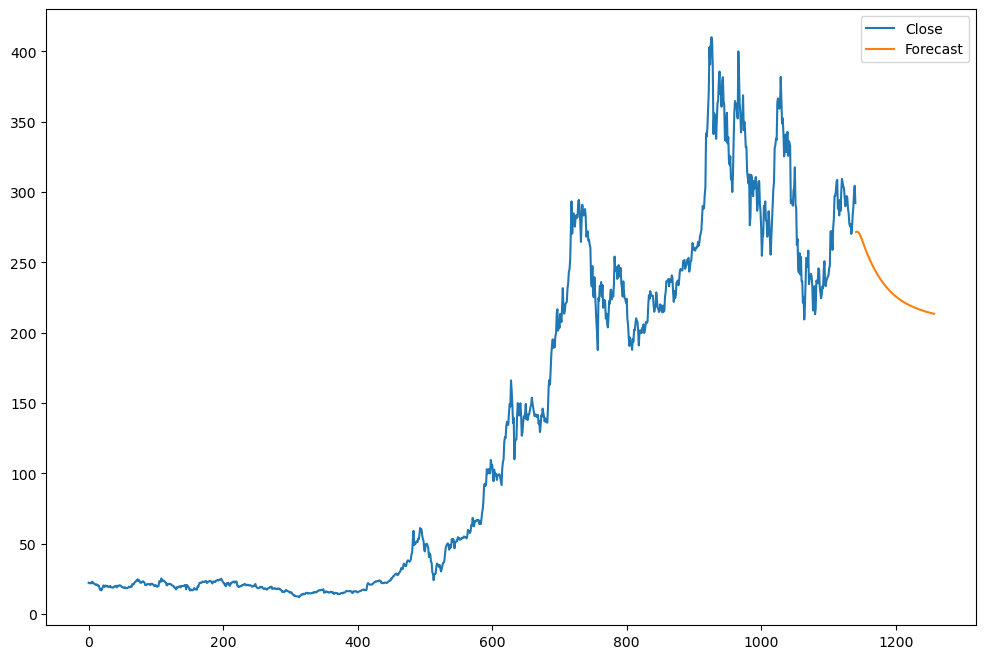

In [89]:
ax=df.plot()
forecast_df.plot(ax=ax, figsize=(12,8))

In [90]:
df.tail()

,Close
1136,283.700012
1137,289.260010
1138,299.679993
1139,304.420013
1140,292.130005


In [91]:
for idx in forecast_df.index:
    df.loc[idx, 'Close'] = forecast_df.loc[idx, 'Forecast']

df

,Close
0,22.223333
1,21.879999
2,22.153334
3,21.940001
4,21.811333
...,...
1253,213.913344
1254,213.794292
1255,213.677661
1256,213.563425


In [92]:
df_ALL_2022 = 'Downloads/TSLA1.csv'

In [93]:
df_ALL_JUL_DEC_2022 = pd.read_csv(df_ALL_2022)

In [94]:
len(df_ALL_JUL_DEC_2022)

1258

In [95]:
df_JUL_DEC_2022 = df_ALL_JUL_DEC_2022.iloc[:,4:5]

In [96]:
df_JUL_DEC_2022

,Close
0,22.223333
1,21.879999
2,22.153334
3,21.940001
4,21.811333
...,...
1253,196.880005
1254,207.630005
1255,205.710007
1256,202.770004


<AxesSubplot: >

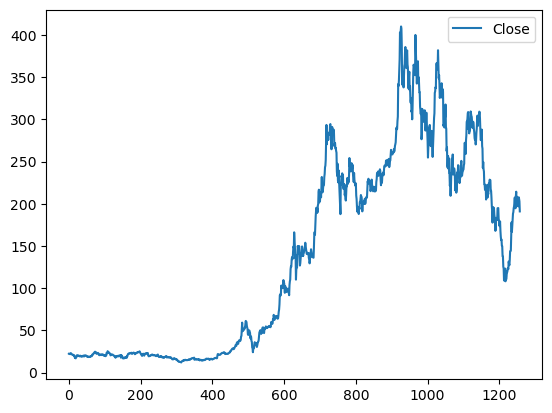

In [97]:
df_JUL_DEC_2022.plot()

In [98]:
forecast_df['Forecast'].values

array([271.53112557, 271.74090161, 271.79022578, 271.57980917,
       271.08825186, 270.34143778, 269.38691173, 268.27781761,
       267.06378801, 265.78657887, 264.47871709, 263.1640937 ,
       261.85891284, 260.57368466, 259.31441158, 258.0843202 ,
       256.8843595 , 255.7145295 , 254.57423706, 253.46239085,
       252.37820793, 251.32059695, 250.28875128, 249.28205406,
       248.29972236, 247.34132914, 246.40632873, 245.49419917,
       244.60458459, 243.73710539, 242.89119218, 242.06644163,
       241.26237923, 240.47864912, 239.71472934, 238.97014541,
       238.24454143, 237.53727684, 236.84813812, 236.17646097,
       235.52203185, 234.88416275, 234.2626876 , 233.65698954,
       233.06676015, 232.49161983, 231.93107035, 231.38492192,
       230.85260514, 230.33388276, 229.82835146, 229.33565535,
       228.85553347, 228.38760621, 227.93161261, 227.48714933,
       227.05397913, 226.63179358, 226.22030799, 225.81923765,
       225.4283216 , 225.04727512, 224.67590842, 224.31

In [99]:
df_JUL_DEC_2022['Forecast'] = df.values

In [100]:
df_JUL_DEC_2022

,Close,Forecast
0,22.223333,22.223333
1,21.879999,21.879999
2,22.153334,22.153334
3,21.940001,21.940001
4,21.811333,21.811333
...,...,...
1253,196.880005,213.913344
1254,207.630005,213.794292
1255,205.710007,213.677661
1256,202.770004,213.563425


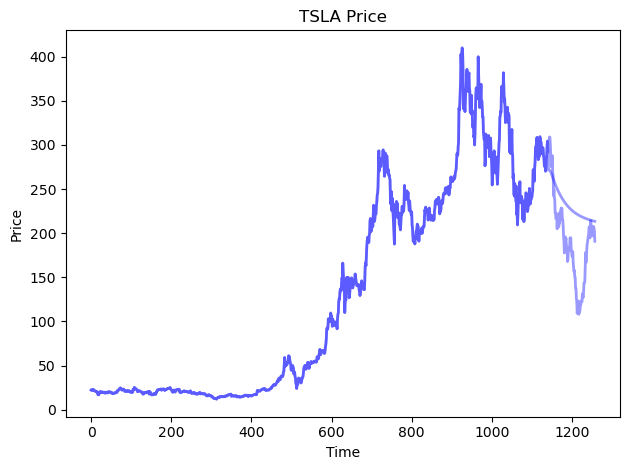

In [101]:
plt.plot(df_JUL_DEC_2022, 'b', linewidth=2, alpha=0.4,)

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('TSLA Price')

plt.tight_layout()